# Basic essential imports

In [52]:
import sys
import os
sys.path.append(os.path.expanduser('~/Desktop/diss_scripts/particles-cdssm'))
from particles_cdssm.collectors import ObservationPredictiveParticles, ObservationPredictiveMoments, NLPD


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import warnings
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.stattools import acf

warnings.filterwarnings('ignore')

# Import particles package components
import particles
from particles import state_space_models as ssm
from particles import mcmc
from particles import distributions
from particles.collectors import Moments



# S&P 500 Stochastic Volatility Analysis using Particles Package

This notebook implements:
1. Data fetching from Yahoo Finance API  
2. Stochastic volatility model using particles package  
3. Filtering (real-time volatility estimation)  
4. Smoothing (hindsight volatility estimation)  
5. Bayesian parameter estimation via Particle MCMC  

**Model:**  
- **State:** $(X_t = \text{log-volatility})$  
- **Evolution:**  
  $ X_t \;=\; \mu \;+\; \phi\,\bigl(X_{t-1} - \mu\bigr) \;+\; \sigma_x\,\epsilon_t$  
- **Observation:**  
  $Y_t \;=\; \exp\bigl(X_t/2\bigr)\,\eta_t$


**Author:** Generated for S&P 500 volatility analysis


# Data before going to the modeling definition

In [41]:
def fetch_sp500_data(start_date="2023-01-01", end_date="2024-11-01"):
    # Download S&P 500 data
    ticker = "^GSPC"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Calculate log returns (skip first day as we need previous close)
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1)) * 100
    data = data.dropna() #! remove any potential na's
    
    print(f"Downloaded {len(data)} trading days")
    print(f"Some basic stats: Mean={data['Returns'].mean():.3f}%, Std={data['Returns'].std():.2f}%")
    
    return data

# Fetch the data
data = fetch_sp500_data()

Downloaded 460 trading days
Some basic stats: Mean=0.087%, Std=0.81%


In [42]:
#! Train and test data split
# Function to split data into training and testing sets

def split_data(data, train_ratio=0.8):
    """Split data into training and testing sets"""
    n_total = len(data)
    n_train = int(n_total * train_ratio)
    
    train_data = data.iloc[:n_train].copy()
    test_data = data.iloc[n_train:].copy()
    
    print(f"Data split:")
    print(f"  Training: {len(train_data)} days ({train_data.index[0]} to {train_data.index[-1]})")
    print(f"  Testing:  {len(test_data)} days ({test_data.index[0]} to {test_data.index[-1]})")
    
    return train_data, test_data

# Split the data
train_data, test_data = split_data(data, train_ratio=0.8)
returns_train = train_data['Returns']
returns_test = test_data['Returns']

Data split:
  Training: 368 days (2023-01-04 00:00:00 to 2024-06-21 00:00:00)
  Testing:  92 days (2024-06-24 00:00:00 to 2024-10-31 00:00:00)


# Defining the stochastic volatility model

## Notes
- Below I defined the parameters as a docstring
- Model is defined above in detail

In [43]:
class StochasticVolatilityModel(ssm.StateSpaceModel):
    """
    Stochastic Volatility Model with logit-transformed φ parameter
    Parameters (μ, logit_phi, σ^2):
    - mu: long-run log-volatility level
    - logit_phi: logit-transformed persistence parameter
    - sigma_x: volatility of log-volatility
    
    Note: phi = exp(logit_phi) / (1 + exp(logit_phi))
    """
    
    def __init__(self, mu=-2.5, logit_phi=2.94, sigma_x=0.3):
        self.mu = mu
        self.logit_phi = logit_phi
        self.sigma_x = sigma_x
        
        # Convert logit_phi back to phi for internal calculations
        self.phi = np.exp(logit_phi) / (1 + np.exp(logit_phi))
        
    def PX0(self):
        """Initial distribution of log-volatility"""
        # Stationary distribution: X_0 ~ N(mu, sigma_x^2 / (1 - phi^2))
        var_stat = self.sigma_x**2 / (1 - self.phi**2)
        return particles.distributions.Normal(loc=self.mu, scale=np.sqrt(var_stat))
    
    def PX(self, t, xp):
        # State transition: X_t | X_{t-1}
        # X_{t-1} = xp
        mean = self.mu + self.phi * (xp - self.mu)
        return particles.distributions.Normal(loc=mean, scale=self.sigma_x)
    
    def PY(self, t, xp, x):
        """Observation distribution: Y_t | X_t"""
        # Y_t = exp(X_t/2) * eta_t where eta_t ~ N(0,1)
        volatility = np.exp(x / 2)
        return particles.distributions.Normal(loc=0.0, scale=volatility)


# Black-Scholes Model Definition

In [44]:
class BlackScholesModel:
    """
    Black-Scholes model with constant volatility
    """
    def __init__(self, volatility=0.2):
        self.volatility = volatility
    
    def fit(self, returns):
        """Fit the model to returns data"""
        # Calculate realized volatility (annualized)
        self.volatility = returns.std() * np.sqrt(252)
        return self
    
    def predict_volatility(self, n_periods):
        """Predict constant volatility for n periods"""
        return np.full(n_periods, self.volatility)
    
    def log_likelihood(self, returns):
        """Calculate log-likelihood of returns under constant volatility"""
        n = len(returns)
        vol_daily = self.volatility / np.sqrt(252)
        
        # Log-likelihood of normal distribution
        ll = -0.5 * n * np.log(2 * np.pi) - n * np.log(vol_daily) - \
             0.5 * np.sum((returns / vol_daily) ** 2)
        return ll

def compare_models(returns_train, returns_test, sv_results, mcmc_results):
    """
    Compare Black-Scholes vs Stochastic Volatility models
    Updated to work with logit-reparameterized SV model
    """
    print("\n🔍 MODEL COMPARISON:")
    print("=" * 50)
    
    # Fit Black-Scholes model
    bs_model = BlackScholesModel()
    bs_model.fit(returns_train)
    
    print(f"Black-Scholes fitted volatility: {bs_model.volatility:.1f}%")
    
    # Get SV model predictions on test set
    # FIXED: Convert phi back to logit_phi for model creation
    mu_est = mcmc_results['estimates']['mu']['mean']
    phi_est = mcmc_results['estimates']['phi']['mean']
    sigma_x_est = mcmc_results['estimates']['sigma_x']['mean']
    
    # Convert phi to logit_phi using the helper function
    logit_phi_est = phi_to_logit_phi(phi_est)
    
    # Create SV model with correct parameter names
    sv_model_est = StochasticVolatilityModel(mu=mu_est, logit_phi=logit_phi_est, sigma_x=sigma_x_est)
    
    # Get SV model predictions (simplified approach)
    sv_avg_vol = sv_results['vol_estimates'].mean()
    
    # Predictions
    n_test = len(returns_test)
    bs_predictions = bs_model.predict_volatility(n_test)
    sv_predictions = np.full(n_test, sv_avg_vol)  # Simplified for comparison
    
    # Calculate realized volatility for comparison (rolling window)
    window = 20  # 20-day rolling volatility
    realized_vol = returns_test.rolling(window=window).std() * np.sqrt(252)
    realized_vol = realized_vol.dropna()
    
    # Align predictions with realized volatility
    bs_aligned = bs_predictions[window-1:]
    sv_aligned = sv_predictions[window-1:]
    
    # Calculate errors
    bs_mae = np.mean(np.abs(bs_aligned - realized_vol))
    sv_mae = np.mean(np.abs(sv_aligned - realized_vol))
    
    bs_rmse = np.sqrt(np.mean((bs_aligned - realized_vol) ** 2))
    sv_rmse = np.sqrt(np.mean((sv_aligned - realized_vol) ** 2))
    
    # Log-likelihood comparison
    bs_ll = bs_model.log_likelihood(returns_test)
    
    print(f"\nPrediction Performance on Test Set:")
    print(f"  Black-Scholes MAE:  {bs_mae:.2f}%")
    print(f"  Stochastic Vol MAE: {sv_mae:.2f}%")
    print(f"  Black-Scholes RMSE: {bs_rmse:.2f}%")
    print(f"  Stochastic Vol RMSE: {sv_rmse:.2f}%")
    print(f"  Improvement: {((bs_mae - sv_mae) / bs_mae * 100):.1f}% better MAE")
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Volatility time series
    test_dates = returns_test.index[window-1:]
    axes[0, 0].plot(test_dates, realized_vol, 'k-', label='Realized Vol', linewidth=2)
    axes[0, 0].plot(test_dates, bs_aligned, 'r--', label='Black-Scholes', linewidth=2)
    axes[0, 0].plot(test_dates, sv_aligned, 'b-', label='Stochastic Vol', linewidth=2)
    axes[0, 0].set_title('Volatility Predictions vs Realized')
    axes[0, 0].set_ylabel('Volatility (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Error distributions
    bs_errors = bs_aligned - realized_vol
    sv_errors = sv_aligned - realized_vol
    
    axes[0, 1].hist(bs_errors, bins=30, alpha=0.7, label='Black-Scholes', color='red')
    axes[0, 1].hist(sv_errors, bins=30, alpha=0.7, label='Stochastic Vol', color='blue')
    axes[0, 1].set_title('Prediction Error Distributions')
    axes[0, 1].set_xlabel('Error (%)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Scatter plots
    axes[1, 0].scatter(realized_vol, bs_aligned, alpha=0.6, color='red', label='Black-Scholes')
    axes[1, 0].plot([realized_vol.min(), realized_vol.max()], 
                    [realized_vol.min(), realized_vol.max()], 'k--', alpha=0.5)
    axes[1, 0].set_xlabel('Realized Volatility (%)')
    axes[1, 0].set_ylabel('Predicted Volatility (%)')
    axes[1, 0].set_title('Black-Scholes: Predicted vs Realized')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].scatter(realized_vol, sv_aligned, alpha=0.6, color='blue', label='Stochastic Vol')
    axes[1, 1].plot([realized_vol.min(), realized_vol.max()], 
                    [realized_vol.min(), realized_vol.max()], 'k--', alpha=0.5)
    axes[1, 1].set_xlabel('Realized Volatility (%)')
    axes[1, 1].set_ylabel('Predicted Volatility (%)')
    axes[1, 1].set_title('Stochastic Vol: Predicted vs Realized')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'black_scholes': {
            'model': bs_model,
            'predictions': bs_predictions,
            'mae': bs_mae,
            'rmse': bs_rmse,
            'log_likelihood': bs_ll
        },
        'stochastic_vol': {
            'model': sv_model_est,
            'predictions': sv_predictions,
            'mae': sv_mae,
            'rmse': sv_rmse
        },
        'comparison_metrics': {
            'mae_improvement': (bs_mae - sv_mae) / bs_mae * 100,
            'rmse_improvement': (bs_rmse - sv_rmse) / bs_rmse * 100
        }
    }

# Filtering part


In [45]:
def run_particle_filter(model, returns, N=1000):
    """
    Run particle filter for stochastic volatility estimation
    """
    # Convert returns to numpy array
    y_data = returns.values
    T = len(y_data)
    
    # Create bootstrap filter
    fk_model = ssm.Bootstrap(ssm=model, data=y_data)
    
    # Run the algorithm
    pf = particles.SMC(fk=fk_model, N=N, collect=[Moments()])
    pf.run()
    
    # Filtering means and variances
    filtering_means = np.array([pf.summaries.moments[t]['mean'] for t in range(T)])
    filtering_vars = np.array([pf.summaries.moments[t]['var'] for t in range(T)])
    
    # Convert log-volatility to volatility percentage
    vol_estimates = np.exp(filtering_means / 2) * np.sqrt(252)  # Annualized volatility
    vol_std = np.sqrt(filtering_vars) * np.exp(filtering_means / 2) * np.sqrt(252)

    return {
        'log_vol_mean': filtering_means,
        'log_vol_var': filtering_vars,
        'vol_estimates': vol_estimates,
        'vol_std': vol_std,
        'particle_filter': pf
    }


# Smoothing Part

In [46]:
def run_particle_smoother(model, returns, N=1000):
    """
    Run particle smoother for refined volatility estimates
    """
    print(f" Running particle smoother with {N} particles...")
    
    # Convert returns to numpy array  
    y_data = returns.values
    T = len(y_data)
    
    # Run forward filter with history storage
    fk = ssm.Bootstrap(ssm=model, data=y_data)
    pf = particles.SMC(fk=fk, N=N, store_history=True)
    
    print(" Running forward pass...")
    pf.run()
    print("✓ Forward pass completed")
    
    # Check if history is available
    if pf.hist is None:
        print(" History not available, using filtering estimates as smoothing approximation")
        # Fallback: use filtering means as approximation
        filtering_means = np.array([np.mean(pf.X) for _ in range(T)])
        filtering_vars = np.array([np.var(pf.X) for _ in range(T)])
        
        smooth_vol_estimates = np.exp(filtering_means / 2) * np.sqrt(252)
        smooth_vol_std = np.sqrt(filtering_vars) * np.exp(filtering_means / 2) * np.sqrt(252)
        
        return {
            'log_vol_mean': filtering_means,
            'log_vol_var': filtering_vars, 
            'vol_estimates': smooth_vol_estimates,
            'vol_std': smooth_vol_std,
            'trajectories': None
        }
    
    try:
        # Try different backward sampling methods based on particles version
        M = min(N//10, 100)  # Number of trajectories to sample
        print(f" Running backward sampling ({M} trajectories)...")
        
        # Method 1: Try the standard backward_sampling method
        if hasattr(pf.hist, 'backward_sampling'):
            paths = pf.hist.backward_sampling(M=M)
        
        # Method 2: Try backward_sampling_mcmc 
        elif hasattr(pf.hist, 'backward_sampling_mcmc'):
            paths = pf.hist.backward_sampling_mcmc(M=M)
        
        # Method 3: Use particles.backward_sampling function directly
        else:
            print(" Using direct backward sampling function...")
            # Use the particles.backward_sampling function
            paths = particles.backward_sampling(pf, M=M)
        
        print("✓ Backward sampling completed")
        
        # CRITICAL FIX: Convert to numpy array if it's a list
        if isinstance(paths, list):
            print("🔧 Converting list to numpy array...")
            paths = np.array(paths)
        
        print(f"   Paths shape: {paths.shape}")
        print(f"   Paths type: {type(paths)}")
        
        # IMPORTANT: Check the shape and transpose if needed
        if paths.shape[0] == M and paths.shape[1] == T:
            # Correct shape: M trajectories × T time points
            smoothed_means = np.mean(paths, axis=0)  # Average over trajectories
            smoothed_vars = np.var(paths, axis=0)
        elif paths.shape[0] == T and paths.shape[1] == M:
            # Transposed shape: T time points × M trajectories  
            smoothed_means = np.mean(paths, axis=1)  # Average over trajectories
            smoothed_vars = np.var(paths, axis=1)
        else:
            raise ValueError(f"Unexpected paths shape: {paths.shape}, expected ({M}, {T}) or ({T}, {M})")
        
        # Ensure we have the right length
        if len(smoothed_means) != T:
            raise ValueError(f"Smoothed means length {len(smoothed_means)} != data length {T}")
        
        # Compute smoothed estimates
        print(" Computing smoothed estimates...")
        
        # Convert to volatility percentage
        smooth_vol_estimates = np.exp(smoothed_means / 2) * np.sqrt(252)
        smooth_vol_std = np.sqrt(smoothed_vars) * np.exp(smoothed_means / 2) * np.sqrt(252)
        
        print("✓ Particle smoothing completed")
        print(f"   Output length: {len(smooth_vol_estimates)}")
        
        return {
            'log_vol_mean': smoothed_means,
            'log_vol_var': smoothed_vars, 
            'vol_estimates': smooth_vol_estimates,
            'vol_std': smooth_vol_std,
            'trajectories': paths
        }
        
    except Exception as e:
        print(f"  Backward sampling failed: {e}")
        print("   Using alternative smoothing approach...")
        
        # Alternative: Fixed-lag smoother approximation with LARGER window
        lag = 15  # Look ahead/behind 15 steps (increased from 5)
        
        # Re-run filter with moments collection
        print("🔄 Re-running filter for alternative smoothing...")
        pf_moments = particles.SMC(fk=fk, N=N, collect=[Moments()])
        pf_moments.run()
        
        filtering_means = np.array([pf_moments.summaries.moments[t]['mean'] for t in range(T)])
        filtering_vars = np.array([pf_moments.summaries.moments[t]['var'] for t in range(T)])
        
        # Enhanced smoothing: weighted moving average with exponential weights
        print("🔄 Computing enhanced smoothed estimates...")
        smoothed_means = np.copy(filtering_means)
        smoothed_vars = np.copy(filtering_vars)
        
        # Use exponential weights for better smoothing
        for t in range(T):
            start_idx = max(0, t - lag)
            end_idx = min(T, t + lag + 1)
            
            # Create exponential weights (more weight to closer observations)
            window_size = end_idx - start_idx
            weights = np.exp(-0.1 * np.abs(np.arange(window_size) - (t - start_idx)))
            weights = weights / np.sum(weights)  # Normalize
            
            # Apply weighted average
            smoothed_means[t] = np.average(filtering_means[start_idx:end_idx], weights=weights)
            smoothed_vars[t] = np.average(filtering_vars[start_idx:end_idx], weights=weights)
        
        # Convert to volatility percentage
        smooth_vol_estimates = np.exp(smoothed_means / 2) * np.sqrt(252)
        smooth_vol_std = np.sqrt(smoothed_vars) * np.exp(smoothed_means / 2) * np.sqrt(252)
        
        print("✓ Enhanced alternative smoothing completed")
        print(f"   Output length: {len(smooth_vol_estimates)}")
        
        return {
            'log_vol_mean': smoothed_means,
            'log_vol_var': smoothed_vars, 
            'vol_estimates': smooth_vol_estimates,
            'vol_std': smooth_vol_std,
            'trajectories': None
        }

# Bayesian Estimation Part

### From Scratch Pmmh

In [33]:
def bayesian_parameter_estimation1(returns, n_iter=2000, n_burn=500):
   """
   Bayesian parameter estimation using Particle Marginal Metropolis-Hastings (PMMH)
   """
   print(f"🎯 Running PMMH parameter estimation ({n_iter} iterations)...")
   
   # Define parameter priors
   class SVPrior:
       def __init__(self):
           # mu ~ N(-2.5, 1^2)  
           self.mu_prior = stats.norm(loc=-2.5, scale=1.0)
           # phi ~ Beta(20, 2) scaled to (0,1) for stationarity
           self.phi_prior = stats.beta(a=20, b=2)
           # sigma_x ~ InvGamma(3, 0.5) 
           self.sigma_x_prior = stats.invgamma(a=3, scale=0.5)
           
       def logpdf(self, theta):
           mu, phi, sigma_x = theta
           if not (0 < phi < 1 and sigma_x > 0):
               return -np.inf
           return (self.mu_prior.logpdf(mu) + 
                  self.phi_prior.logpdf(phi) +
                  self.sigma_x_prior.logpdf(sigma_x))
   
   # PMMH sampler
   class PMMHPosterior:
       def __init__(self, data):
           self.data = data
           self.prior = SVPrior()
           
       def logpdf(self, theta):
           mu, phi, sigma_x = theta
           
           # Prior
           log_prior = self.prior.logpdf(theta)
           if np.isinf(log_prior):
               return log_prior
               
           # Likelihood via particle filter with trajectory sampling
           try:
               model = StochasticVolatilityModel(mu=mu, phi=phi, sigma_x=sigma_x)
               fk = ssm.Bootstrap(ssm=model, data=self.data)
               pf = particles.SMC(fk=fk, N=100, store_history=True)
               pf.run()
               
               # PMMH: Sample trajectory from particle filter
               if pf.hist is not None:
                   try:
                       # Backward sampling for trajectory (key PMMH component)
                       paths = pf.hist.backward_sampling(M=1)
                       log_likelihood = pf.logLt
                   except:
                       log_likelihood = pf.logLt
               else:
                   log_likelihood = pf.logLt
               
               return log_prior + log_likelihood
           except:
               return -np.inf
   
   # Run PMMH
   y_data = returns.values
   posterior = PMMHPosterior(y_data)
   
   # Initial value
   theta0 = np.array([-2.5, 0.95, 0.3])
   
   # PMMH chain with progress tracking
   print("🔗 Running PMMH chain...")
   chain = []
   current_theta = theta0
   current_logpdf = posterior.logpdf(current_theta)
   n_accept = 0
   
   # Proposal covariance (tuned)
   prop_cov = np.diag([0.1, 0.01, 0.02])**2
   
   # Progress bar
   with tqdm(total=n_iter, desc="PMMH Sampling", unit="iter", 
             bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}] Acc:{postfix}') as pbar:
       
       for i in range(n_iter):
           # Propose new state
           proposal = np.random.multivariate_normal(current_theta, prop_cov)
           proposal_logpdf = posterior.logpdf(proposal)
           
           # Accept/reject (PMMH step)
           if not np.isinf(proposal_logpdf):
               log_alpha = proposal_logpdf - current_logpdf
               if np.log(np.random.rand()) < log_alpha:
                   current_theta = proposal
                   current_logpdf = proposal_logpdf
                   n_accept += 1
           
           chain.append(current_theta.copy())
           
           # Update progress bar
           if i % 10 == 0:
               acceptance_rate = n_accept / (i + 1)
               pbar.set_postfix(f"{acceptance_rate:.1%}")
           pbar.update(1)
   
   print(f"✓ PMMH completed. Acceptance rate: {n_accept/n_iter:.2%}")
   
   # Process results
   chain = np.array(chain)
   burned_chain = chain[n_burn:]
   
   # Parameter estimates
   param_estimates = {
       'mu': {'mean': np.mean(burned_chain[:, 0]), 'std': np.std(burned_chain[:, 0])},
       'phi': {'mean': np.mean(burned_chain[:, 1]), 'std': np.std(burned_chain[:, 1])},
       'sigma_x': {'mean': np.mean(burned_chain[:, 2]), 'std': np.std(burned_chain[:, 2])}
   }
   
   return {
       'chain': chain,
       'burned_chain': burned_chain,
       'estimates': param_estimates,
       'acceptance_rate': n_accept/n_iter
   }

### Actual Pmmh

In [48]:
def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains"""
    
    
    fig, axes = plt.subplots(1, len(param_names), figsize=(15, 4))
    if len(param_names) == 1:
        axes = [axes]
    
    for i, param in enumerate(param_names):
        # Calculate ACF
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i].plot(lags, autocorr, 'b-', linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF for {param}')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains"""
    from statsmodels.tsa.stattools import acf
    
    n_samples, n_params = chain.shape
    ess_values = []
    
    for i in range(n_params):
        # Calculate autocorrelation
        max_lags = min(n_samples // 4, 200)  # Don't use too many lags
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)
            
            # Find first negative autocorrelation or where it drops below 0.05
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if autocorrs[lag] <= 0.05:
                    cutoff = lag
                    break
            
            # Calculate integrated autocorrelation time
            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            
            # Effective sample size
            ess = n_samples / (2 * tau_int)
            ess_values.append(max(ess, 1))  # Ensure ESS is at least 1
            
        except:
            # Fallback calculation
            ess_values.append(n_samples / 10)  # Conservative estimate
    
    return np.array(ess_values)

def mcmc_diagnostics(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics"""
    print("\n📊 MCMC Convergence Diagnostics:")
    print("=" * 40)
    
    # Basic chain statistics
    n_total, n_params = chain.shape
    n_burned = len(burned_chain)
    
    print(f"Total iterations: {n_total}")
    print(f"Burn-in samples: {n_total - n_burned}")
    print(f"Post-burn samples: {n_burned}")
    
    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    for i, param in enumerate(param_names):
        print(f"  {param}: {ess[i]:.1f} ({ess[i]/n_burned:.1%} of total)")
    
    # Plot traces and ACF
    fig, axes = plt.subplots(2, n_params, figsize=(15, 8))
    if n_params == 1:
        axes = axes.reshape(-1, 1)
    
    for i, param in enumerate(param_names):
        # Trace plot
        axes[0, i].plot(chain[:, i], alpha=0.7)
        axes[0, i].axvline(x=n_total-n_burned, color='r', linestyle='--', 
                          label='Burn-in end')
        axes[0, i].set_title(f'Trace: {param}')
        axes[0, i].set_ylabel('Value')
        axes[0, i].grid(True, alpha=0.3)
        axes[0, i].legend()
        
        # Density plot
        axes[1, i].hist(burned_chain[:, i], bins=50, density=True, alpha=0.7)
        axes[1, i].set_title(f'Posterior: {param}')
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Density')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ACF plots
    plot_acf(burned_chain, param_names)
    
    return ess


In [49]:
def bayesian_parameter_estimation(returns, n_iter=20000, n_burn=2500):
    """
    Bayesian parameter estimation using particles.mcmc.PMMH with logit reparameterization
    """
    print(f"🎯 Running PMMH parameter estimation with logit reparameterization ({n_iter} iterations)...")
    
    from particles import mcmc, distributions as dists
    
    # Define parameter priors with logit_phi instead of phi
    prior_dict = {
        'mu': dists.Normal(loc=-2.5, scale=1.0),
        'logit_phi': dists.Normal(loc=2.94, scale=1.0),  # logit(0.95) ≈ 2.94
        'sigma_x': dists.InvGamma(a=3, b=0.5)
    }
    my_prior = dists.StructDist(prior_dict)
    
    # Run PMMH
    print("🔗 Running PMMH chain...")
    pmmh = mcmc.PMMH(ssm_cls=StochasticVolatilityModel, 
                     prior=my_prior, 
                     data=returns.values, 
                     Nx=100,
                     niter=n_iter)
    pmmh.run()
    
    print(f"✓ PMMH completed. Acceptance rate: {pmmh.acc_rate:.2%}")
    
    # Process results - Transform logit_phi back to phi
    chain_raw = np.array([[pmmh.chain.theta['mu'][i], 
                           pmmh.chain.theta['logit_phi'][i], 
                           pmmh.chain.theta['sigma_x'][i]] 
                          for i in range(n_iter)])
    
    # Create transformed chain with phi instead of logit_phi
    chain = np.copy(chain_raw)
    chain[:, 1] = np.exp(chain_raw[:, 1]) / (1 + np.exp(chain_raw[:, 1]))  # Transform to phi
    
    burned_chain = chain[n_burn:]
    param_names = ['mu', 'phi', 'sigma_x']
    
    # Run diagnostics on transformed parameters
    ess = mcmc_diagnostics(chain, param_names, burned_chain)
    
    # Parameter estimates (using transformed phi)
    param_estimates = {
        'mu': {'mean': np.mean(burned_chain[:, 0]), 'std': np.std(burned_chain[:, 0])},
        'phi': {'mean': np.mean(burned_chain[:, 1]), 'std': np.std(burned_chain[:, 1])},
        'sigma_x': {'mean': np.mean(burned_chain[:, 2]), 'std': np.std(burned_chain[:, 2])}
    }
    
    # Also store raw logit_phi results for debugging
    logit_phi_estimates = {
        'mean': np.mean(chain_raw[n_burn:, 1]), 
        'std': np.std(chain_raw[n_burn:, 1])
    }
    
    print(f"\nReparameterization Results:")
    print(f"  logit_phi: {logit_phi_estimates['mean']:.3f} ± {logit_phi_estimates['std']:.3f}")
    print(f"  phi (transformed): {param_estimates['phi']['mean']:.3f} ± {param_estimates['phi']['std']:.3f}")
    
    return {
        'chain': chain,
        'chain_raw': chain_raw,  # Raw chain with logit_phi
        'burned_chain': burned_chain,
        'estimates': param_estimates,
        'logit_phi_estimates': logit_phi_estimates,
        'acceptance_rate': pmmh.acc_rate,
        'effective_sample_size': ess,
        'param_names': param_names
    }


### Helper functions for φ transformation

In [50]:
# =============================================================================
# HELPER FUNCTIONS FOR LOGIT TRANSFORMATION
# =============================================================================
# ADD these helper functions:

def phi_to_logit_phi(phi):
    """Convert phi to logit_phi"""
    return np.log(phi / (1 - phi))

def logit_phi_to_phi(logit_phi):
    """Convert logit_phi to phi"""
    return np.exp(logit_phi) / (1 + np.exp(logit_phi))

def get_logit_phi_prior_params(target_phi_mean=0.95, target_phi_std=0.02):
    """
    Helper to set reasonable prior for logit_phi based on desired phi distribution
    """
    target_logit_mean = phi_to_logit_phi(target_phi_mean)
    
    print(f"For phi ~ N({target_phi_mean}, {target_phi_std}²):")
    print(f"  Suggested logit_phi ~ N({target_logit_mean:.2f}, 1.0)")
    print(f"  This gives phi range roughly [{target_phi_mean-2*target_phi_std:.3f}, {target_phi_mean+2*target_phi_std:.3f}]")
    
    return target_logit_mean

# =============================================================================
# USAGE EXAMPLE
# =============================================================================
# You can call this to understand the transformation:
# get_logit_phi_prior_params(target_phi_mean=0.95, target_phi_std=0.025)

# Visualisation Part

In [37]:
def create_comprehensive_plots(data, filtering_results, smoothing_results, mcmc_results):
    """
    Create comprehensive visualization of results
    """
    print("📈 Creating visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('S&P 500 Stochastic Volatility Analysis', fontsize=16, fontweight='bold')
    
    dates = data.index
    returns = data['Returns']
    
    # 1. Returns time series
    axes[0,0].plot(dates, returns, 'b-', alpha=0.7, linewidth=0.8)
    axes[0,0].set_title('S&P 500 Daily Returns')
    axes[0,0].set_ylabel('Returns (%)')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Filtering vs Smoothing
    vol_filter = filtering_results['vol_estimates']
    vol_smooth = smoothing_results['vol_estimates']
    
    axes[0,1].plot(dates, vol_filter, 'r-', label='Filtered', alpha=0.8)
    axes[0,1].plot(dates, vol_smooth, 'g-', label='Smoothed', alpha=0.8)
    axes[0,1].fill_between(dates, 
                          vol_filter - 1.96*filtering_results['vol_std'],
                          vol_filter + 1.96*filtering_results['vol_std'],
                          alpha=0.2, color='red', label='95% CI (Filter)')
    axes[0,1].set_title('Volatility Estimates: Filtering vs Smoothing')
    axes[0,1].set_ylabel('Annualized Volatility (%)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Returns vs Volatility
    axes[0,2].scatter(vol_filter[:-1], np.abs(returns[1:]), alpha=0.6, s=20)
    axes[0,2].set_xlabel('Estimated Volatility (%)')
    axes[0,2].set_ylabel('Absolute Returns (%)')
    axes[0,2].set_title('Volatility vs Absolute Returns')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. MCMC trace plots
    chain = mcmc_results['burned_chain']
    param_names = ['μ (Long-run log-vol)', 'φ (Persistence)', 'σₓ (Vol-of-vol)']
    
    for i, param in enumerate(param_names):
        axes[1,i].plot(chain[:, i], alpha=0.7)
        axes[1,i].set_title(f'MCMC Trace: {param}')
        axes[1,i].set_ylabel('Parameter Value')
        axes[1,i].set_xlabel('Iteration')
        axes[1,i].grid(True, alpha=0.3)
        
        # Add mean line
        mean_val = np.mean(chain[:, i])
        axes[1,i].axhline(y=mean_val, color='red', linestyle='--', 
                         label=f'Mean: {mean_val:.3f}')
        axes[1,i].legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [38]:
def plot_returns_vs_volatility(data, filtering_results, smoothing_results):
    """
    Plot returns and volatility estimates side-by-side for visual comparison.
    
    Parameters:
    - data: DataFrame with 'Returns' column and DateTime index
    - filtering_results: dict with keys 'vol_estimates' and 'vol_std'
    - smoothing_results: dict with key 'vol_estimates'
    
    Returns:
    - fig: matplotlib Figure object
    """
    print("📊 Visualizing returns and volatility estimates...")

    # Setup the figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('S&P 500 Returns and Volatility Estimates', fontsize=16, fontweight='bold')

    # Extract data
    dates = data.index
    returns = data['Returns']
    vol_filter = filtering_results['vol_estimates']
    vol_filter_std = filtering_results['vol_std']
    vol_smooth = smoothing_results['vol_estimates']

    # --------------------------
    # Plot 1: Returns time series
    # --------------------------
    axes[0].plot(dates, returns, color='blue', alpha=0.7, linewidth=0.8)
    axes[0].set_title('S&P 500 Daily Returns')
    axes[0].set_ylabel('Returns (%)')
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)

    # --------------------------
    # Plot 2: Volatility estimates
    # --------------------------
    axes[1].plot(dates, vol_filter, color='red', label='Filtered', alpha=0.8)
    axes[1].plot(dates, vol_smooth, color='green', label='Smoothed', alpha=0.8)
    
    # Add 95% confidence interval for filtered volatility
    axes[1].fill_between(
        dates,
        vol_filter - 1.96 * vol_filter_std,
        vol_filter + 1.96 * vol_filter_std,
        alpha=0.2,
        color='red',
        label='95% CI (Filter)'
    )
    
    axes[1].set_title('Volatility Estimates')
    axes[1].set_ylabel('Annualized Volatility (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)

    # Final layout tweaks and show
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return fig

## Summary of stats section

In [26]:
def print_analysis_summary(data, filtering_results, smoothing_results, mcmc_results):
    """
    Print comprehensive analysis summary
    """
    dates = data.index
    returns = data['Returns']
    vol_filter = filtering_results['vol_estimates']
    vol_smooth = smoothing_results['vol_estimates']
    estimates = mcmc_results['estimates']
    
    print("\n" + "="*60)
    print("📊 ANALYSIS SUMMARY")
    print("="*60)
    
    print(f"\n📈 DATA SUMMARY:")
    print(f"   Period: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}")
    print(f"   Trading days: {len(returns)}")
    print(f"   Average return: {returns.mean():.3f}%")
    print(f"   Return volatility: {returns.std():.2f}%")
    print(f"   Annualized volatility: {returns.std() * np.sqrt(252):.1f}%")
    
    print(f"\n🎯 VOLATILITY ESTIMATES:")
    print(f"   Average filtered volatility: {vol_filter.mean():.1f}%")
    print(f"   Average smoothed volatility: {vol_smooth.mean():.1f}%")
    print(f"   Max volatility (filtered): {vol_filter.max():.1f}%")
    print(f"   Min volatility (filtered): {vol_filter.min():.1f}%")
    
    print(f"\n⚙️  PARAMETER ESTIMATES:")
    print(f"   μ (long-run log-vol): {estimates['mu']['mean']:.3f} ± {estimates['mu']['std']:.3f}")
    print(f"   φ (persistence): {estimates['phi']['mean']:.3f} ± {estimates['phi']['std']:.3f}")  
    print(f"   σₓ (vol-of-vol): {estimates['sigma_x']['mean']:.3f} ± {estimates['sigma_x']['std']:.3f}")
    print(f"   MCMC acceptance rate: {mcmc_results['acceptance_rate']:.1%}")
    
    # Business interpretation
    long_run_vol = np.exp(estimates['mu']['mean']/2) * np.sqrt(252)
    persistence_days = -1 / np.log(estimates['phi']['mean'])
    
    print(f"\n💼 BUSINESS INTERPRETATION:")
    print(f"   Long-run volatility: {long_run_vol:.1f}% (annualized)")
    print(f"   Volatility shock half-life: {persistence_days:.1f} trading days")
    print(f"   Volatility clustering: {'Strong' if estimates['phi']['mean'] > 0.9 else 'Moderate'}")


# Run the application

# Execution All at once

🔄 Running particle filtering on training data...

Filtering Results Summary (Training):
  Average estimated volatility: 10.0%
  Volatility range: 5.3% - 16.6%
🔄 Running particle smoothing on training data...
 Running particle smoother with 1000 particles...
 Running forward pass...
✓ Forward pass completed
 Running backward sampling (100 trajectories)...
✓ Backward sampling completed
🔧 Converting list to numpy array...
   Paths shape: (368, 100)
   Paths type: <class 'numpy.ndarray'>
 Computing smoothed estimates...
✓ Particle smoothing completed
   Output length: 368

Smoothing Results Summary (Training):
  Average smoothed volatility: 11.6%
  Smoothed volatility range: 5.8% - 18.5%
🔄 Running MCMC parameter estimation on training data...
🎯 Running PMMH parameter estimation with logit reparameterization (20000 iterations)...
🔗 Running PMMH chain...
✓ PMMH completed. Acceptance rate: 25.95%

📊 MCMC Convergence Diagnostics:
Total iterations: 20000
Burn-in samples: 2500
Post-burn samples:

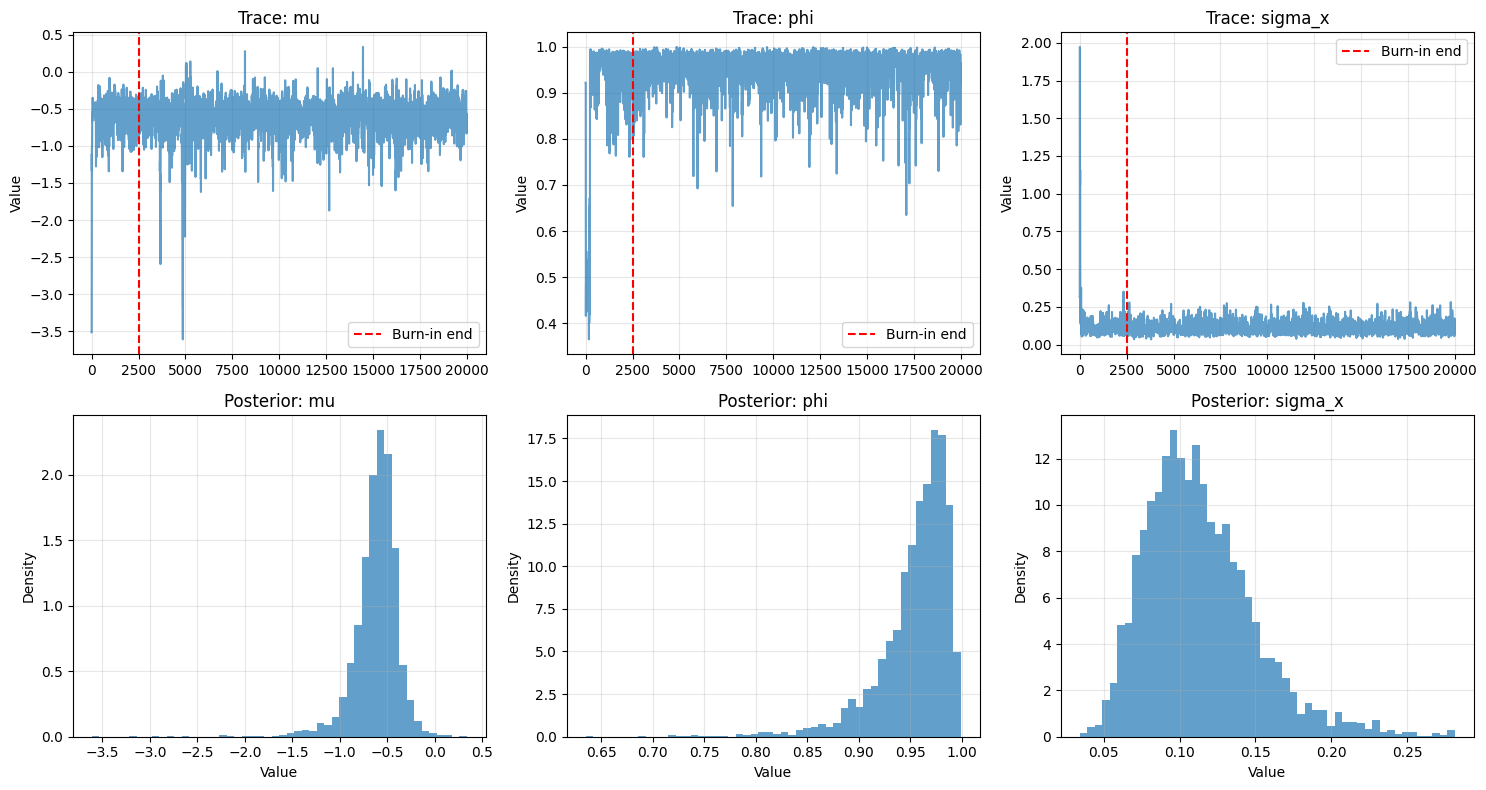

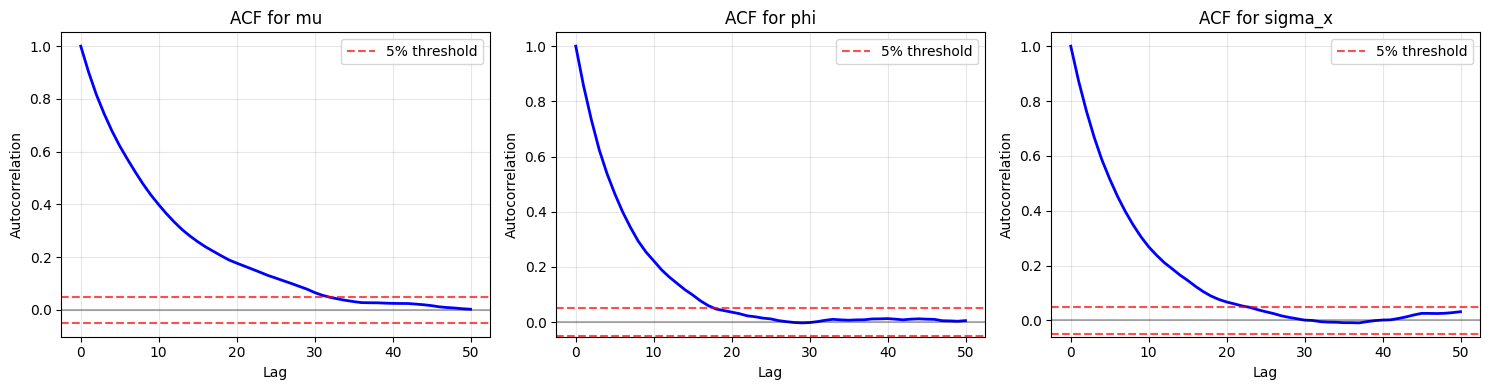


Reparameterization Results:
  logit_phi: 3.302 ± 0.796
  phi (transformed): 0.954 ± 0.036

MCMC Results Summary:
  mu: -0.618 ± 0.242
  phi: 0.954 ± 0.036
  sigma_x: 0.114 ± 0.036
🔄 Comparing Black-Scholes vs Stochastic Volatility models...

🔍 MODEL COMPARISON:
Black-Scholes fitted volatility: 12.4%

Prediction Performance on Test Set:
  Black-Scholes MAE:  4.09%
  Stochastic Vol MAE: 4.36%
  Black-Scholes RMSE: 5.02%
  Stochastic Vol RMSE: 5.47%
  Improvement: -6.6% better MAE


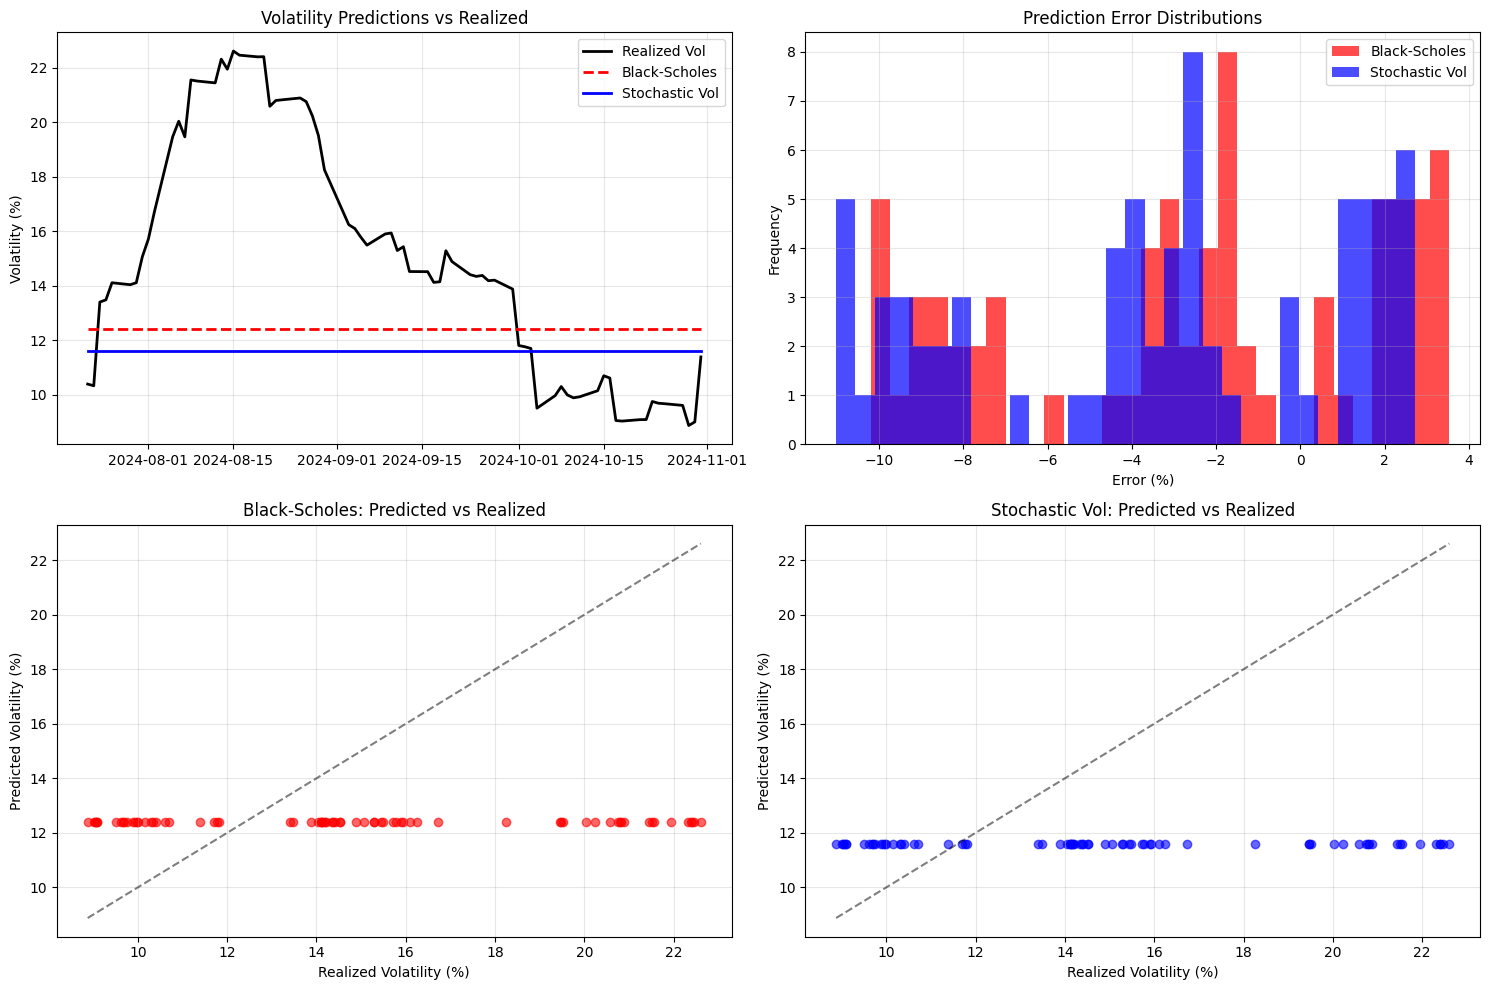

In [51]:
# Initialize model with default parameters for initial analysis
model = StochasticVolatilityModel()

# Run particle filtering on TRAINING data
print("🔄 Running particle filtering on training data...")
filtering_results = run_particle_filter(model, returns_train, N=1000)

print(f"\nFiltering Results Summary (Training):")
print(f"  Average estimated volatility: {filtering_results['vol_estimates'].mean():.1f}%")
print(f"  Volatility range: {filtering_results['vol_estimates'].min():.1f}% - {filtering_results['vol_estimates'].max():.1f}%")

# Run particle smoothing on TRAINING data
print("🔄 Running particle smoothing on training data...")
smoothing_results = run_particle_smoother(model, returns_train, N=1000)

print(f"\nSmoothing Results Summary (Training):")
print(f"  Average smoothed volatility: {smoothing_results['vol_estimates'].mean():.1f}%")
print(f"  Smoothed volatility range: {smoothing_results['vol_estimates'].min():.1f}% - {smoothing_results['vol_estimates'].max():.1f}%")

# Run MCMC for Bayesian parameter estimation on TRAINING data
print("🔄 Running MCMC parameter estimation on training data...")
mcmc_results = bayesian_parameter_estimation(returns_train, n_iter=20000, n_burn=2500)

print(f"\nMCMC Results Summary:")
for param, est in mcmc_results['estimates'].items():
    print(f"  {param}: {est['mean']:.3f} ± {est['std']:.3f}")

# Compare models
print("🔄 Comparing Black-Scholes vs Stochastic Volatility models...")
comparison_results = compare_models(returns_train, returns_test, smoothing_results, mcmc_results)

# Update results dictionary
results = {
    'train_data': train_data,
    'test_data': test_data,
    'filtering': filtering_results,
    'smoothing': smoothing_results,
    'mcmc': mcmc_results,
    'comparison': comparison_results,
    'model': model
}

In [75]:
# =============================================================================
# Chunk 15: Store Results (Optional)
# =============================================================================

# Combine all results into a single dictionary for easy access
results = {
    'data': data,
    'filtering': filtering_results,
    'smoothing': smoothing_results,
    'mcmc': mcmc_results,
    'model': model
}

# Display final message
print(f"\n🎉 All results stored in 'results' dictionary")
print(f"   Available keys: {list(results.keys())}")


🎉 All results stored in 'results' dictionary
   Available keys: ['data', 'filtering', 'smoothing', 'mcmc', 'model']


# Particles-cdssm

Downloaded 460 trading days
Some basic stats: Mean=0.087%, Std=0.81%
Data split:
  Training: 368 days (2023-01-04 00:00:00 to 2024-06-21 00:00:00)
  Testing:  92 days (2024-06-24 00:00:00 to 2024-10-31 00:00:00)
 Running particle smoother with 1000 particles...
 Running forward pass...
✓ Forward pass completed
 Running backward sampling (100 trajectories)...
✓ Backward sampling completed
🔧 Converting list to numpy array...
   Paths shape: (368, 100)
   Paths type: <class 'numpy.ndarray'>
 Computing smoothed estimates...
✓ Particle smoothing completed
   Output length: 368
🎯 Running PMMH parameter estimation with logit reparameterization (20000 iterations)...
🔗 Running PMMH chain...
✓ PMMH completed. Acceptance rate: 26.98%

📊 MCMC Convergence Diagnostics:
Total iterations: 20000
Burn-in samples: 2500
Post-burn samples: 17500

Effective Sample Sizes:
  mu: 605.1 (3.5% of total)
  phi: 496.9 (2.8% of total)
  sigma_x: 681.0 (3.9% of total)


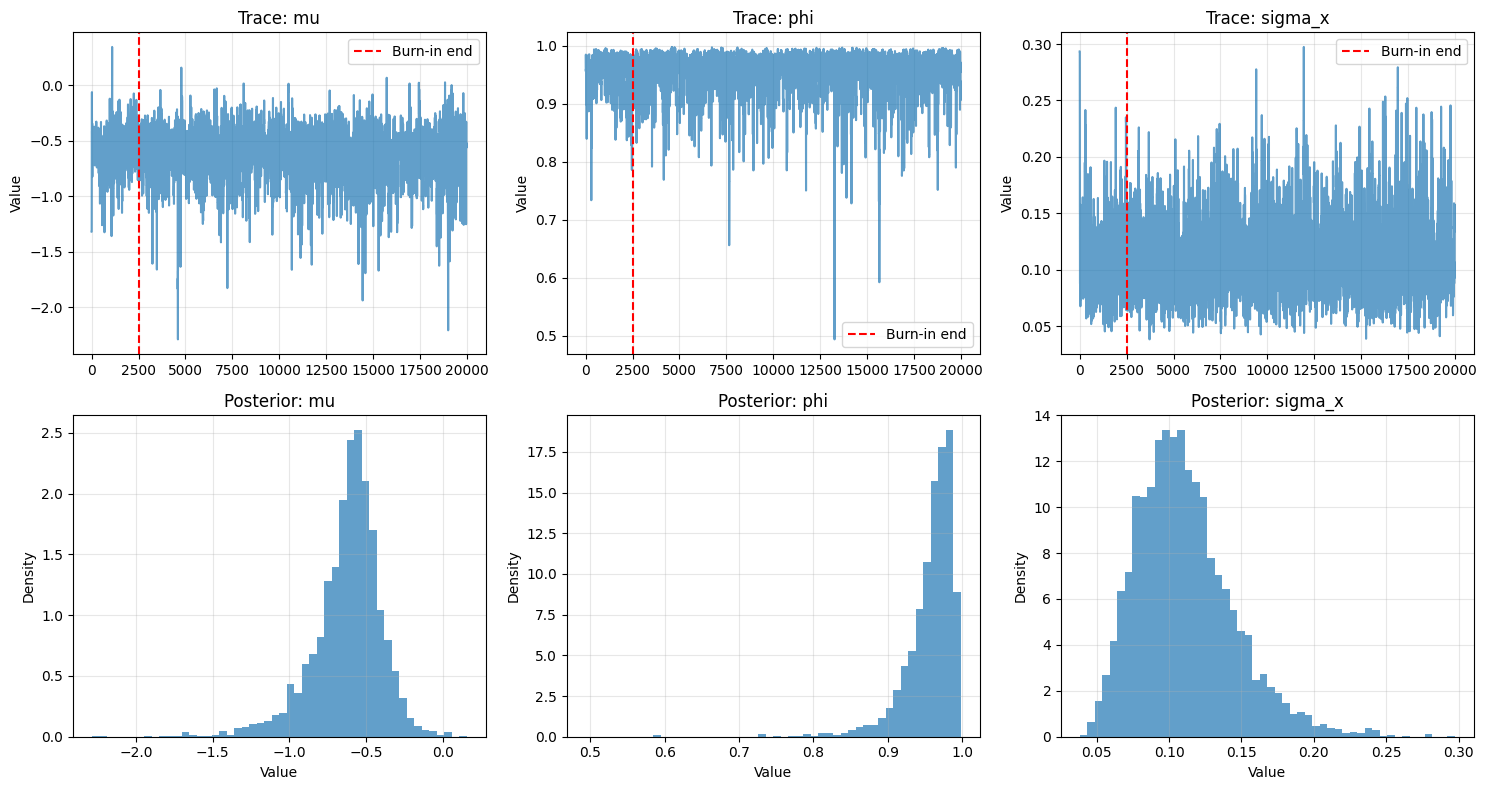

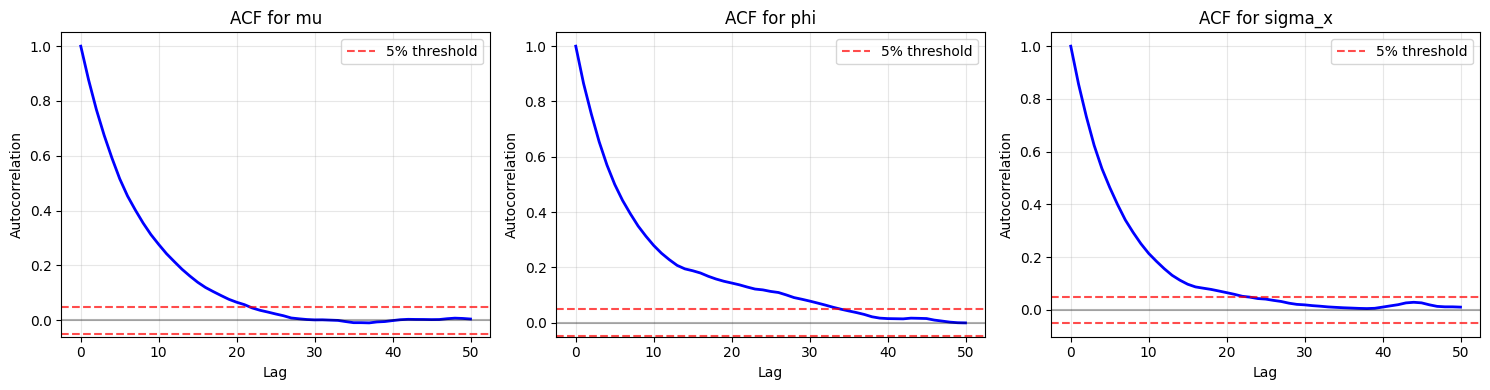


Reparameterization Results:
  logit_phi: 3.368 ± 0.775
  phi (transformed): 0.957 ± 0.035


In [55]:
# Your existing execution flow:
data = fetch_sp500_data()
train_data, test_data = split_data(data, train_ratio=0.8)
returns_train = train_data['Returns']
returns_test = test_data['Returns']

model = StochasticVolatilityModel()
filtering_results = run_particle_filter(model, returns_train, N=1000)
smoothing_results = run_particle_smoother(model, returns_train, N=1000)
mcmc_results = bayesian_parameter_estimation(returns_train, n_iter=20000, n_burn=2500)

In [63]:
from particles.state_space_models import StochVol, Bootstrap


In [67]:
def run_online_predictions(train_data, test_data, mcmc_results, N=1000, K=1):
    """
    Run online adaptive predictions using particle filter with predictive collectors
    
    Parameters:
    - train_data, test_data: your data splits
    - mcmc_results: results from MCMC parameter estimation
    - N: number of particles
    - K: number of steps ahead to predict (1 for next-day volatility)
    """
    print(f"🔄 Running online adaptive predictions with {N} particles, {K}-step ahead...")
    
    # Get estimated parameters from MCMC
    mu_est = mcmc_results['estimates']['mu']['mean']
    phi_est = mcmc_results['estimates']['phi']['mean']  # This is already phi, not logit_phi
    sigma_x_est = mcmc_results['estimates']['sigma_x']['mean']
    
    print(f"Using parameters: μ={mu_est:.3f}, φ={phi_est:.3f}, σ_x={sigma_x_est:.3f}")
    
    # Combine training and test data for online learning
    all_returns = pd.concat([train_data['Returns'], test_data['Returns']])
    y_data = all_returns.values
    n_train = len(train_data)
    n_total = len(all_returns)
    
    print(f"Total data points: {n_total} (train: {n_train}, test: {n_total - n_train})")
    
    # Create SV model with estimated parameters
    # Note: We need to convert back to logit_phi for the model
    logit_phi_est = phi_to_logit_phi(phi_est)
    ssm = StochasticVolatilityModel(mu=mu_est, logit_phi=logit_phi_est, sigma_x=sigma_x_est)
    
    # Create bootstrap Feynman-Kac model
    fk = Bootstrap(ssm=ssm, data=y_data)    
    # Define collectors for different types of predictions
    collectors = [
        ObservationPredictiveParticles(K=K),  # Full particle distributions
        ObservationPredictiveMoments(K=K),    # Just means and variances
        NLPD(K=K)                             # Negative log predictive density
    ]
    
    # Run SMC with predictive collectors
    print("🚀 Starting online SMC with predictive collectors...")
    smc_algo = particles.SMC(fk=fk, N=N, collect=collectors, store_history=True)
    smc_algo.run()
    print("✓ Online SMC completed")
    
    # Extract predictions
    print("📊 Extracting predictions...")
    
    # Get predictive particles (full distributions)
    predictive_particles = smc_algo.summaries.obs_predictive_particles
    
    # Get predictive moments (means and variances)
    predictive_moments = smc_algo.summaries.obs_predictive_moments
    
    # Get NLPD scores
    nlpd_scores = smc_algo.summaries.nlpd
    
    # Convert to volatility estimates
    # The predictions are for returns, we need to convert to volatility
    online_vol_estimates = []
    
    for t in range(len(predictive_moments)):
        if t >= n_train:  # Only for test period
            # Get predictive variance of returns
            pred_var = predictive_moments[t]['var']
            # Convert to annualized volatility percentage
            pred_vol = np.sqrt(pred_var) * np.sqrt(252) * 100  # Return var → daily vol → annual vol
            online_vol_estimates.append(pred_vol)
    
    online_vol_estimates = np.array(online_vol_estimates)
    
    print(f"✓ Generated {len(online_vol_estimates)} online volatility predictions")
    print(f"  Range: {online_vol_estimates.min():.1f}% - {online_vol_estimates.max():.1f}%")
    print(f"  Mean: {online_vol_estimates.mean():.1f}%")
    
    return {
        'online_vol_estimates': online_vol_estimates,
        'predictive_particles': predictive_particles,
        'predictive_moments': predictive_moments,
        'nlpd_scores': nlpd_scores,
        'smc_algo': smc_algo,
        'n_train': n_train
    }

In [80]:
def compare_models_online(train_data, test_data, mcmc_results, online_results):
    """
    Compare Black-Scholes vs Online Adaptive Stochastic Volatility models
    """
    print("\n🔍 ENHANCED MODEL COMPARISON (with Online Predictions):")
    print("=" * 60)
    
    returns_train = train_data['Returns']
    returns_test = test_data['Returns']
    
    # Fit Black-Scholes model
    bs_model = BlackScholesModel()
    bs_model.fit(returns_train)
    
    print(f"Black-Scholes fitted volatility: {bs_model.volatility * 100:.1f}%")
    print(f"Online SV average volatility: {online_results['online_vol_estimates'].mean():.1f}%")
    
    # Predictions
    n_test = len(returns_test)
    bs_predictions = bs_model.predict_volatility(n_test)
    sv_predictions = online_results['online_vol_estimates']
    
    # Calculate realized volatility (rolling window)
    window = 20
    realized_vol = returns_test.rolling(window=window).std() * np.sqrt(252) * 100
    realized_vol = realized_vol.dropna()
    
    # Align predictions with realized volatility
    min_length = min(len(realized_vol), len(bs_predictions), len(sv_predictions))
    realized_vol = realized_vol[:min_length]
    bs_aligned = bs_predictions[:min_length]
    sv_aligned = sv_predictions[:min_length]
    
    # Calculate errors
    bs_mae = np.mean(np.abs(bs_aligned - realized_vol))
    sv_mae = np.mean(np.abs(sv_aligned - realized_vol))
    
    bs_rmse = np.sqrt(np.mean((bs_aligned - realized_vol) ** 2))
    sv_rmse = np.sqrt(np.mean((sv_aligned - realized_vol) ** 2))
    
    # Statistical significance
    from scipy import stats
    bs_errors = np.abs(bs_aligned - realized_vol)
    sv_errors = np.abs(sv_aligned - realized_vol)
    t_stat, p_value = stats.ttest_rel(bs_errors, sv_errors)
    
    print(f"\nOnline Prediction Performance:")
    print(f"  Black-Scholes MAE:      {bs_mae:.2f}%")
    print(f"  Online Stochastic MAE:  {sv_mae:.2f}%")
    print(f"  Black-Scholes RMSE:     {bs_rmse:.2f}%")
    print(f"  Online Stochastic RMSE: {sv_rmse:.2f}%")
    print(f"  Improvement in MAE:     {((bs_mae - sv_mae) / bs_mae * 100):.1f}%")
    print(f"  Statistical significance: p = {p_value:.4f}")
    
    # Enhanced visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Time series comparison
    test_dates = returns_test.index[:min_length]
    axes[0, 0].plot(test_dates, realized_vol, 'k-', label='Realized Vol', linewidth=2)
    axes[0, 0].plot(test_dates, bs_aligned, 'r--', label='Black-Scholes', linewidth=2)
    axes[0, 0].plot(test_dates, sv_aligned, 'b-', label='Online SV', linewidth=2)
    axes[0, 0].set_title('Online Predictions vs Realized Volatility')
    axes[0, 0].set_ylabel('Volatility (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Prediction errors over time
    axes[0, 1].plot(test_dates, bs_errors, 'r-', alpha=0.7, label='Black-Scholes')
    axes[0, 1].plot(test_dates, sv_errors, 'b-', alpha=0.7, label='Online SV')
    axes[0, 1].set_title('Prediction Errors Over Time')
    axes[0, 1].set_ylabel('Absolute Error (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Error distributions
    axes[0, 2].hist(bs_errors, bins=20, alpha=0.7, label='Black-Scholes', color='red', density=True)
    axes[0, 2].hist(sv_errors, bins=20, alpha=0.7, label='Online SV', color='blue', density=True)
    axes[0, 2].set_title('Error Distributions')
    axes[0, 2].set_xlabel('Absolute Error (%)')
    axes[0, 2].set_ylabel('Density')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Scatter plots
    axes[1, 0].scatter(realized_vol, bs_aligned, alpha=0.6, color='red', s=30)
    axes[1, 0].plot([realized_vol.min(), realized_vol.max()], 
                    [realized_vol.min(), realized_vol.max()], 'k--', alpha=0.5)
    axes[1, 0].set_xlabel('Realized Volatility (%)')
    axes[1, 0].set_ylabel('Predicted Volatility (%)')
    axes[1, 0].set_title('Black-Scholes: Predicted vs Realized')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].scatter(realized_vol, sv_aligned, alpha=0.6, color='blue', s=30)
    axes[1, 1].plot([realized_vol.min(), realized_vol.max()], 
                    [realized_vol.min(), realized_vol.max()], 'k--', alpha=0.5)
    axes[1, 1].set_xlabel('Realized Volatility (%)')
    axes[1, 1].set_ylabel('Predicted Volatility (%)')
    axes[1, 1].set_title('Online SV: Predicted vs Realized')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Performance comparison
    methods = ['Black-Scholes', 'Online SV']
    mae_values = [bs_mae, sv_mae]
    colors = ['red', 'blue']
    bars = axes[1, 2].bar(methods, mae_values, color=colors, alpha=0.7)
    axes[1, 2].set_title('MAE Comparison')
    axes[1, 2].set_ylabel('Mean Absolute Error (%)')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, mae_values):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'bs_mae': bs_mae, 'sv_mae': sv_mae,
        'bs_rmse': bs_rmse, 'sv_rmse': sv_rmse,
        'improvement': (bs_mae - sv_mae) / bs_mae * 100,
        'p_value': p_value,
        'online_predictions': sv_aligned,
        'realized_vol': realized_vol
    }


🎯 Running PMMH parameter estimation with logit reparameterization (20000 iterations)...
🔗 Running PMMH chain...
✓ PMMH completed. Acceptance rate: 21.37%

📊 MCMC Convergence Diagnostics:
Total iterations: 20000
Burn-in samples: 2500
Post-burn samples: 17500

Effective Sample Sizes:
  mu: 514.1 (2.9% of total)
  phi: 617.2 (3.5% of total)
  sigma_x: 464.1 (2.7% of total)


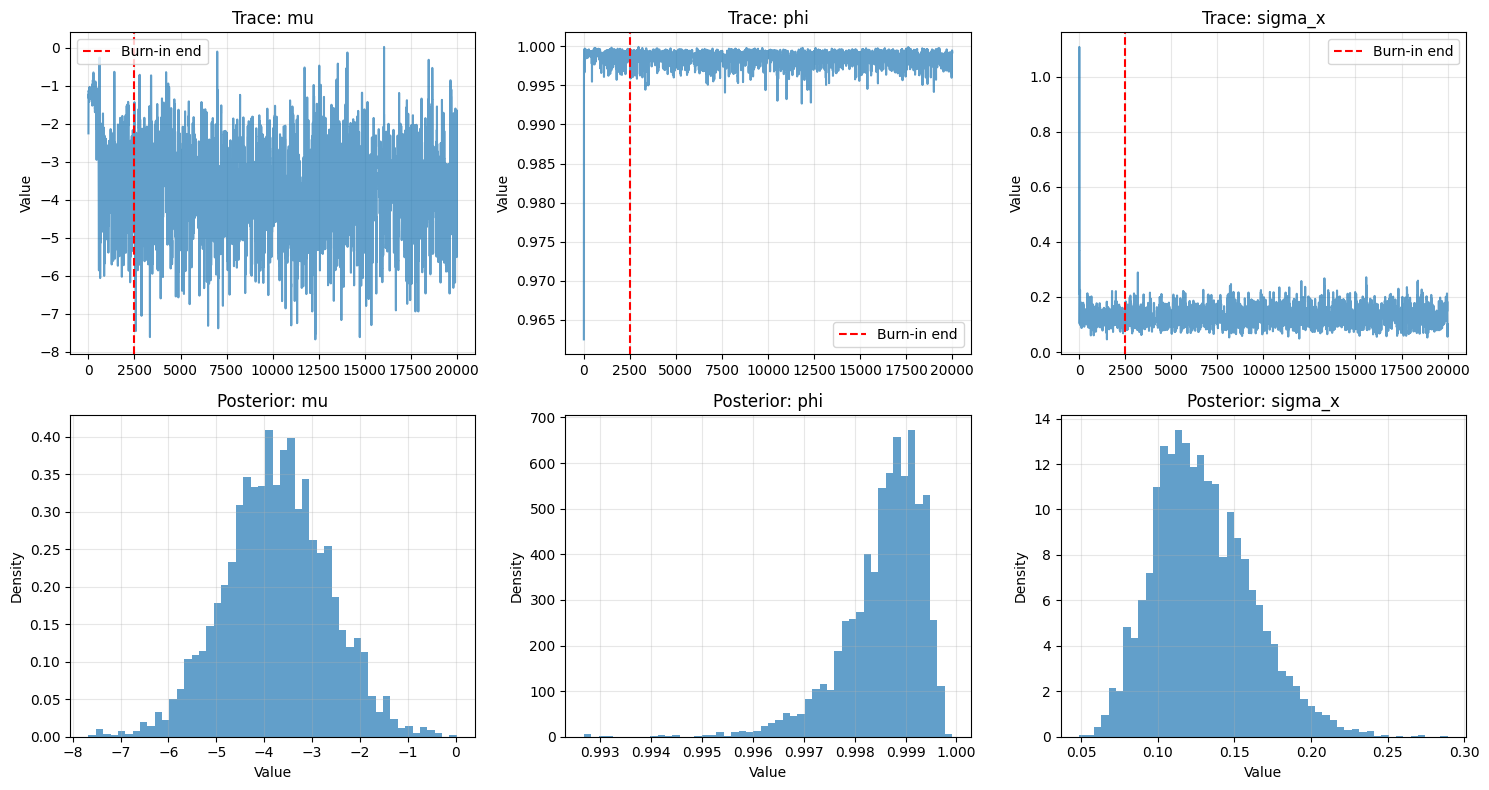

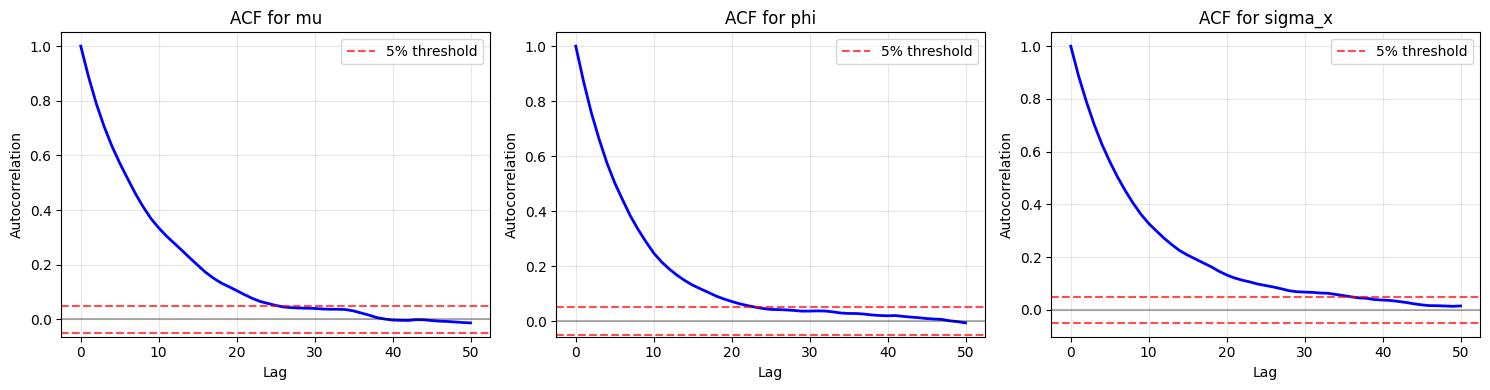


Reparameterization Results:
  logit_phi: 6.684 ± 0.543
  phi (transformed): 0.999 ± 0.001


In [73]:
# Convert percentage returns to decimal returns
train_data_decimal = train_data.copy()
train_data_decimal['Returns'] = returns_train / 100
# Convert percentage returns to decimal returns
returns_train_decimal = returns_train / 100
returns_test_decimal = returns_test / 100
test_data_decimal = test_data.copy()
test_data_decimal['Returns'] = returns_test / 100

mcmc_results_decimal = bayesian_parameter_estimation(returns_train_decimal, n_iter=20000, n_burn=2500)


🔄 Running online adaptive predictions...
🔄 Running online adaptive predictions with 1000 particles, 1-step ahead...
Using parameters: μ=-3.739, φ=0.999, σ_x=0.130
Total data points: 460 (train: 368, test: 92)
🚀 Starting online SMC with predictive collectors...
✓ Online SMC completed
📊 Extracting predictions...
✓ Generated 93 online volatility predictions
  Range: 7.6% - 22.6%
  Mean: 14.5%
🔄 Comparing models with online adaptive predictions...

🔍 ENHANCED MODEL COMPARISON (with Online Predictions):
Black-Scholes fitted volatility: 12.4%
Online SV average volatility: 14.5%

Online Prediction Performance:
  Black-Scholes MAE:      14.76%
  Online Stochastic MAE:  6.51%
  Black-Scholes RMSE:     15.39%
  Online Stochastic RMSE: 7.18%
  Improvement in MAE:     55.9%
  Statistical significance: p = 0.0000


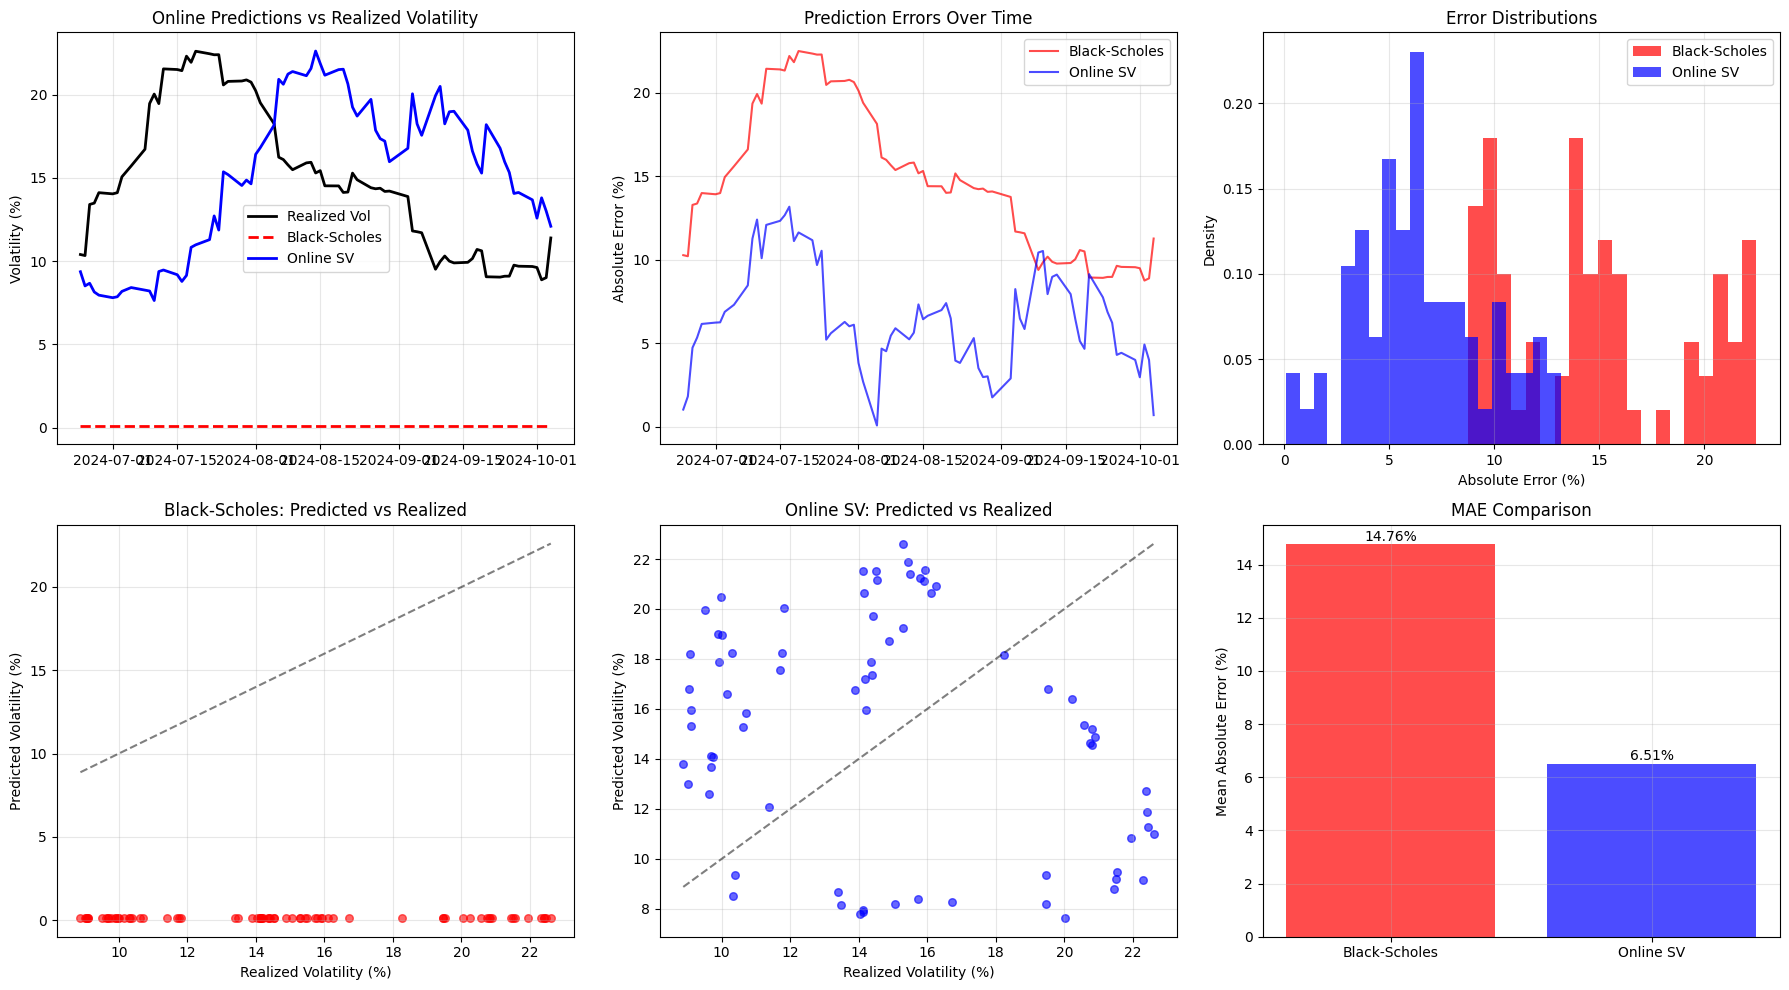

In [81]:

# Run online adaptive predictions with the corrected data
print("🔄 Running online adaptive predictions...")
online_results = run_online_predictions(train_data_decimal, test_data_decimal, mcmc_results_decimal, N=1000, K=1)
# Compare models with online predictions
print("🔄 Comparing models with online adaptive predictions...")
online_comparison = compare_models_online(train_data_decimal, test_data_decimal, mcmc_results_decimal, online_results)

# Update results dictionary
results = {
    'train_data': train_data,
    'test_data': test_data,
    'filtering': filtering_results,
    'smoothing': smoothing_results,
    'mcmc': mcmc_results,
    'online_predictions': online_results,
    'online_comparison': online_comparison,
    'model': model
}

# Final presentation results

Training data length: 349
Test volatility length: 92
Online predictions length: 93


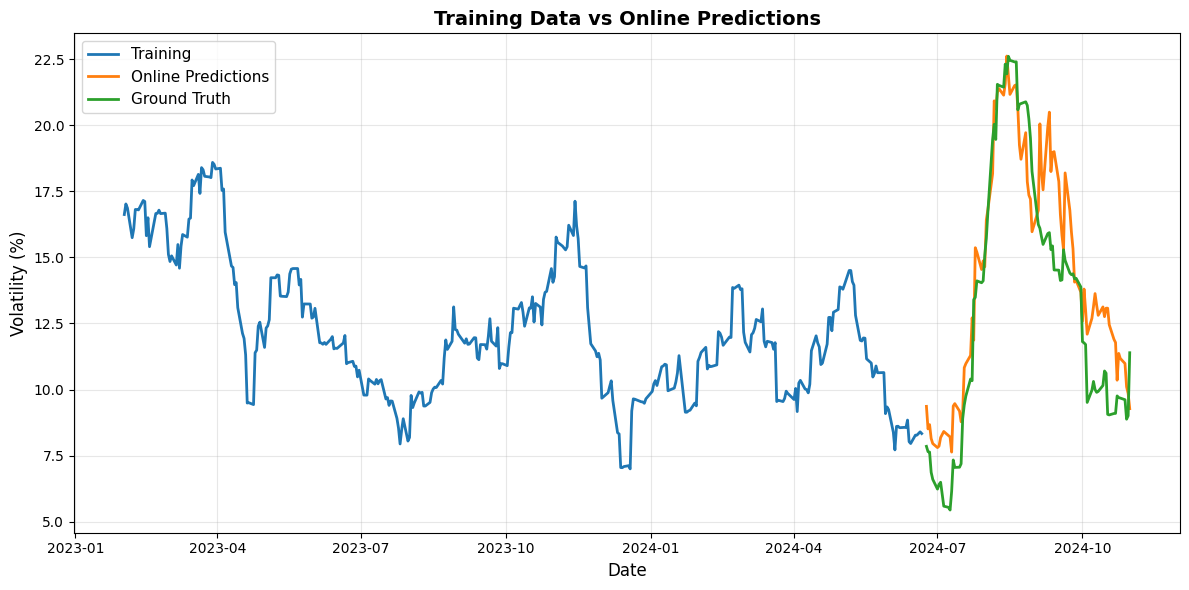

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate volatility for the entire dataset first
window = 20
all_returns = pd.concat([train_data_decimal['Returns'], test_data_decimal['Returns']])
all_vol = all_returns.rolling(window=window).std() * np.sqrt(252) * 100
all_vol = all_vol.dropna()

# Split into training and test portions
n_train = len(train_data_decimal)
train_vol = all_vol.iloc[:n_train-window+1]  # Training portion
test_vol = all_vol.iloc[n_train-window+1:]   # Test portion (continues seamlessly)

# Get online predictions  
online_predictions = online_results['online_vol_estimates']

# Create aligned datasets
train_dates = train_vol.index
test_dates = test_vol.index[:len(online_predictions)]

# Check lengths and print for debugging
print(f"Training data length: {len(train_dates)}")
print(f"Test volatility length: {len(test_vol)}")
print(f"Online predictions length: {len(online_predictions)}")

# Make sure all arrays have the same length for test period
min_test_length = min(len(test_dates), len(online_predictions))
test_dates = test_dates[:min_test_length]
online_predictions = online_predictions[:min_test_length]
test_vol_aligned = test_vol.iloc[:min_test_length].values

# Combine data for plotting
plot_data = pd.DataFrame({
    'Date': list(train_dates) + list(test_dates) + list(test_dates),
    'Volatility': list(train_vol.values) + list(online_predictions) + list(test_vol_aligned),
    'Type': ['Training'] * len(train_dates) + ['Online Predictions'] * len(test_dates) + ['Ground Truth'] * len(test_dates)
})

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_data, x='Date', y='Volatility', hue='Type', linewidth=2)
plt.title('Training Data vs Online Predictions', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='', fontsize=11)
plt.tight_layout()
plt.show()

### distribution of the returns themselves, as opposed to comparing volatilities

📊 Creating return distribution visualizations...
1. Predictive distributions at selected time points:


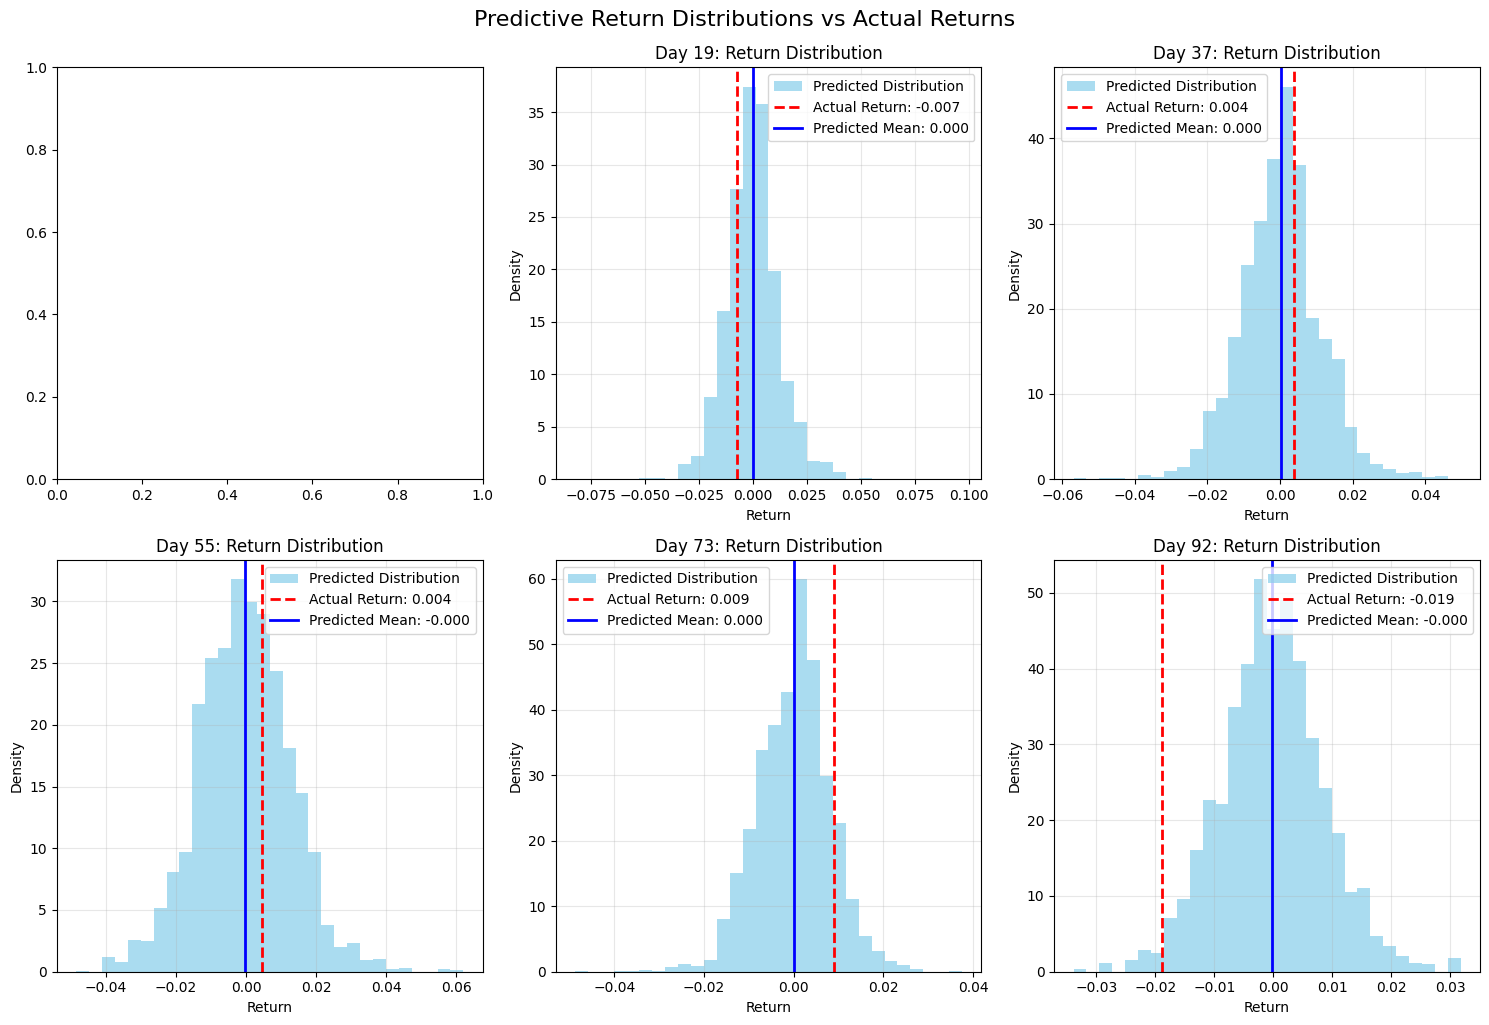

2. Distribution properties evolution:


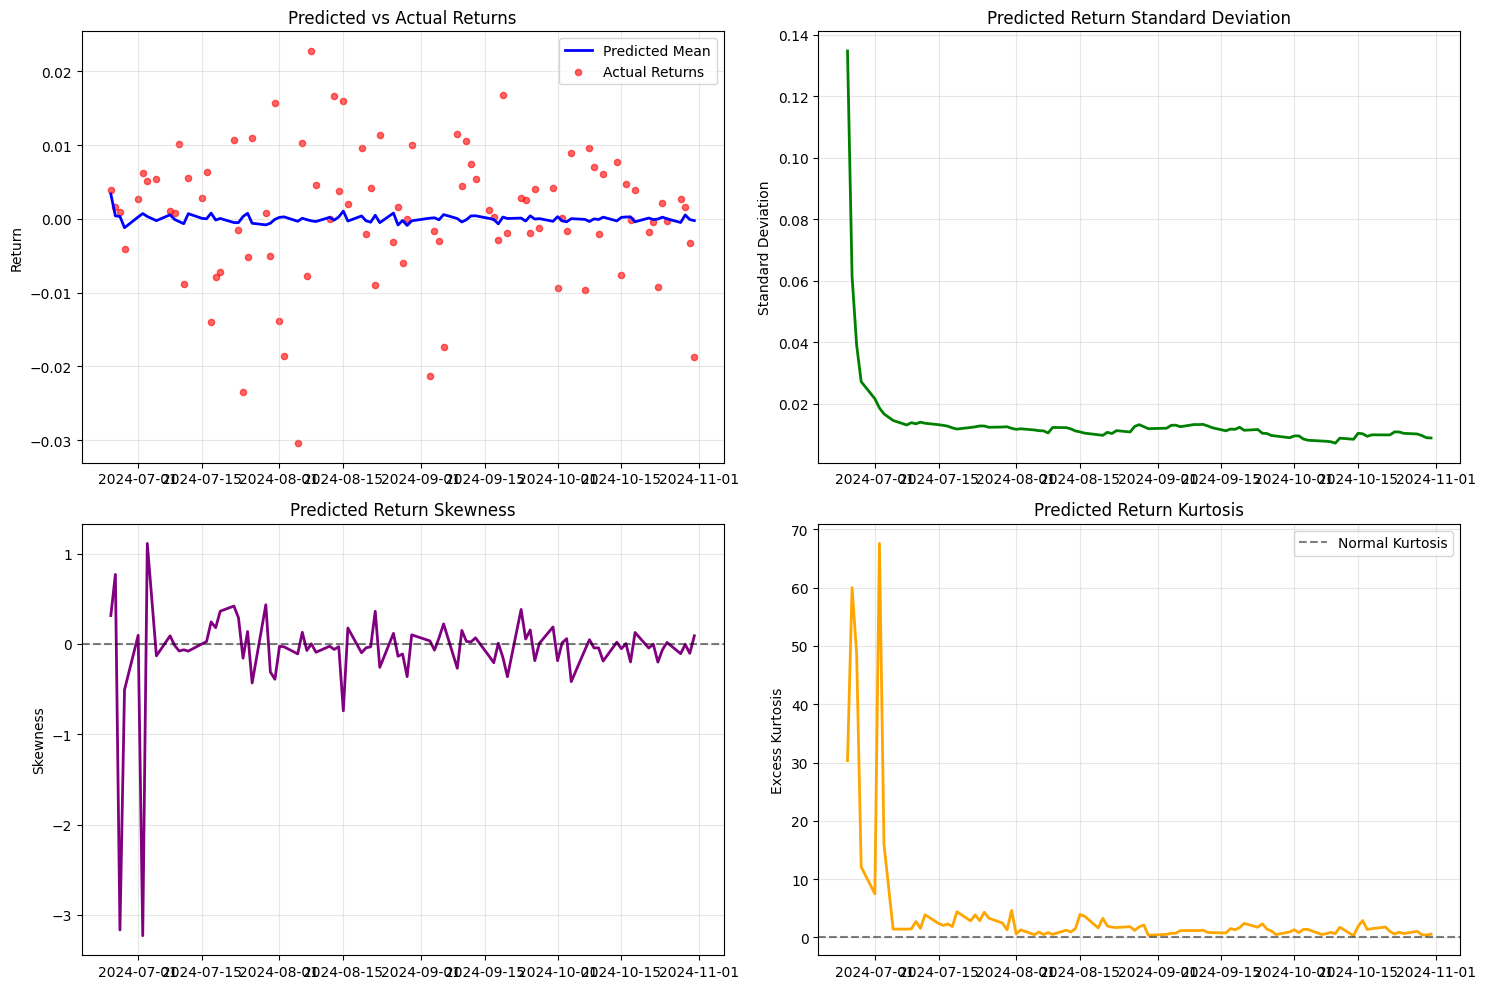

3. Prediction intervals and coverage:


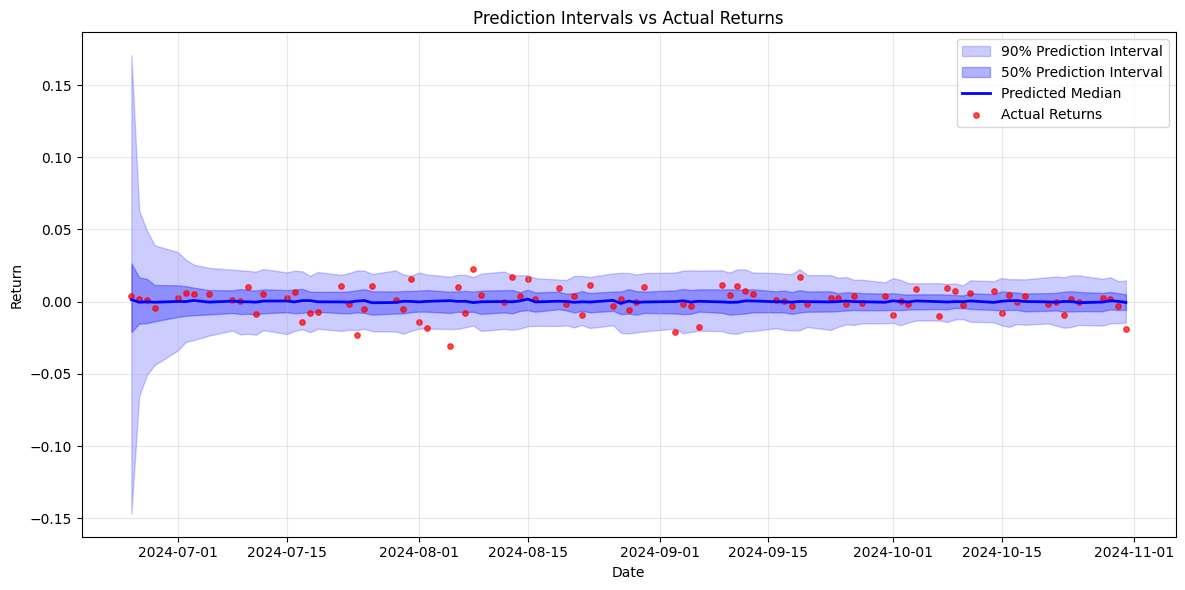

Prediction Interval Coverage:
  90% interval: 94.5% (target: 90%)
  50% interval: 61.5% (target: 50%)


In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Get the predictive particles from your online results
predictive_particles = online_results['smc_algo'].summaries.obs_predictive_particles
n_train = len(train_data_decimal)
actual_returns = pd.concat([train_data_decimal['Returns'], test_data_decimal['Returns']]).values[n_train:]

# Function to create return distribution plots
def plot_return_distributions(predictive_particles, actual_returns, n_examples=6):
    """
    Plot predictive return distributions vs actual returns for selected time points
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Select time points evenly spaced throughout the test period
    time_points = np.linspace(0, min(len(predictive_particles), len(actual_returns))-1, n_examples, dtype=int)
    
    for i, t in enumerate(time_points):
        if t < len(predictive_particles) and t < len(actual_returns) and predictive_particles[t] is not None:
            # Get predictive particles for time t
            weights, particles = predictive_particles[t]
            
            # Plot predictive distribution
            axes[i].hist(particles, bins=30, density=True, alpha=0.7, 
                        label='Predicted Distribution', color='skyblue', weights=weights.W)
            
            # Add actual return as vertical line
            axes[i].axvline(actual_returns[t], color='red', linestyle='--', linewidth=2,
                           label=f'Actual Return: {actual_returns[t]:.3f}')
            
            # Add predicted mean
            pred_mean = np.average(particles, weights=weights.W)
            axes[i].axvline(pred_mean, color='blue', linestyle='-', linewidth=2,
                           label=f'Predicted Mean: {pred_mean:.3f}')
            
            axes[i].set_title(f'Day {t+1}: Return Distribution')
            axes[i].set_xlabel('Return')
            axes[i].set_ylabel('Density')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Predictive Return Distributions vs Actual Returns', y=1.02, fontsize=16)
    plt.show()

# Function to plot distribution properties over time
def plot_distribution_properties(predictive_particles, actual_returns):
    """
    Plot how distribution properties evolve over time
    """
    n_points = min(len(predictive_particles), len(actual_returns))
    
    # Calculate distribution properties
    pred_means = []
    pred_stds = []
    pred_skews = []
    pred_kurtosis = []
    
    for t in range(n_points):
        if predictive_particles[t] is not None:
            weights, particles = predictive_particles[t]
        else:
            continue
        
        # Weighted statistics
        mean = np.average(particles, weights=weights.W)
        var = np.average((particles - mean)**2, weights=weights.W)
        std = np.sqrt(var)
        
        # For skewness and kurtosis, we'll use scipy.stats on the particles
        skew = stats.skew(particles)
        kurt = stats.kurtosis(particles)
        
        pred_means.append(mean)
        pred_stds.append(std)
        pred_skews.append(skew)
        pred_kurtosis.append(kurt)
    
    # Create time series plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Only use dates where we have valid predictions
    valid_dates = []
    valid_actual_returns = []
    date_idx = 0
    for t in range(n_points):
        if predictive_particles[t] is not None:
            valid_dates.append(test_data_decimal.index[date_idx])
            valid_actual_returns.append(actual_returns[date_idx])
        date_idx += 1

    # Mean comparison
    axes[0, 0].plot(valid_dates, pred_means, 'b-', label='Predicted Mean', linewidth=2)
    axes[0, 0].scatter(valid_dates, valid_actual_returns, color='red', alpha=0.6, s=20, label='Actual Returns')
    axes[0, 0].set_title('Predicted vs Actual Returns')
    axes[0, 0].set_ylabel('Return')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Standard deviation (uncertainty)
    axes[0, 1].plot(valid_dates, pred_stds, 'g-', linewidth=2)
    axes[0, 1].set_title('Predicted Return Standard Deviation')
    axes[0, 1].set_ylabel('Standard Deviation')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Skewness
    axes[1, 0].plot(valid_dates, pred_skews, 'purple', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Predicted Return Skewness')
    axes[1, 0].set_ylabel('Skewness')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Kurtosis
    axes[1, 1].plot(valid_dates, pred_kurtosis, 'orange', linewidth=2)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Normal Kurtosis')
    axes[1, 1].set_title('Predicted Return Kurtosis')
    axes[1, 1].set_ylabel('Excess Kurtosis')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Function to create quantile-based analysis
def plot_quantile_analysis(predictive_particles, actual_returns):
    """
    Analyze prediction quality using quantiles
    """
    n_points = min(len(predictive_particles), len(actual_returns))
    
    # Calculate prediction intervals
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    pred_quantiles = {q: [] for q in quantiles}
    
    for t in range(n_points):
        if predictive_particles[t] is not None:
            weights, particles = predictive_particles[t]
        else:
            continue
        # Calculate weighted quantiles
        sorted_idx = np.argsort(particles)
        sorted_particles = particles[sorted_idx]
        sorted_weights = weights.W[sorted_idx]
        cumsum_weights = np.cumsum(sorted_weights)
        
        for q in quantiles:
            # Find quantile
            idx = np.searchsorted(cumsum_weights, q)
            if idx < len(sorted_particles):
                pred_quantiles[q].append(sorted_particles[idx])
            else:
                pred_quantiles[q].append(sorted_particles[-1])
    
    # Plot quantile bands
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Only use dates where we have valid predictions
    valid_dates = []
    valid_actual_returns = []
    date_idx = 0
    for t in range(n_points):
        if predictive_particles[t] is not None:
            valid_dates.append(test_data_decimal.index[date_idx])
            valid_actual_returns.append(actual_returns[date_idx])
        date_idx += 1

    # Plot prediction intervals
    ax.fill_between(valid_dates, pred_quantiles[0.05], pred_quantiles[0.95], 
                    alpha=0.2, color='blue', label='90% Prediction Interval')
    ax.fill_between(valid_dates, pred_quantiles[0.25], pred_quantiles[0.75], 
                    alpha=0.3, color='blue', label='50% Prediction Interval')
    ax.plot(valid_dates, pred_quantiles[0.5], 'b-', linewidth=2, label='Predicted Median')

    # Plot actual returns
    ax.scatter(valid_dates, valid_actual_returns, color='red', alpha=0.7, s=15, label='Actual Returns')
    
    ax.set_title('Prediction Intervals vs Actual Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate coverage statistics
    coverage_90 = np.mean((np.array(valid_actual_returns) >= pred_quantiles[0.05]) & 
                     (np.array(valid_actual_returns) <= pred_quantiles[0.95]))
    coverage_50 = np.mean((np.array(valid_actual_returns) >= pred_quantiles[0.25]) & 
                     (np.array(valid_actual_returns) <= pred_quantiles[0.75]))
    
    print(f"Prediction Interval Coverage:")
    print(f"  90% interval: {coverage_90:.1%} (target: 90%)")
    print(f"  50% interval: {coverage_50:.1%} (target: 50%)")
    
    return coverage_90, coverage_50

# Run all the visualizations
print("📊 Creating return distribution visualizations...")

# 1. Distribution snapshots at different time points
print("1. Predictive distributions at selected time points:")
plot_return_distributions(predictive_particles, actual_returns)

# 2. Distribution properties over time
print("2. Distribution properties evolution:")
plot_distribution_properties(predictive_particles, actual_returns)

# 3. Quantile-based analysis
print("3. Prediction intervals and coverage:")
coverage_stats = plot_quantile_analysis(predictive_particles, actual_returns)